# Data Exploration

In [467]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import seaborn as sns
import glob
import librosa as lb
import librosa.display
import IPython.display as ipd
import os
import re
import warnings

warnings.filterwarnings('ignore')

In [468]:
#style
# plt.rcParams['axes.facecolor'] = '#2E2E2E'    
plt.rcParams['grid.color'] = '#444444'        
plt.rcParams['axes.edgecolor'] = '#444444'    
plt.rcParams['axes.labelcolor'] = 'white'     
plt.rcParams['xtick.color'] = 'white'         
plt.rcParams['ytick.color'] = 'white'         
plt.rcParams['axes.grid'] = True              
plt.rcParams['axes.titlesize'] = 12           
plt.rcParams['axes.titleweight'] = 'bold'     
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'          

sns.set_style("darkgrid") 
custom_palette = ["#00FF00", "#00FFFF", "#FF00FF", "#FF4500", "#1E90FF", "#FFD700", "#ADFF2F", "#FF1493"]
sns.set_palette(custom_palette)


In [469]:
def get_files(path):
    count = 0
    for root, dirs, files in os.walk(path):
        count += len(files)

    print(f'Path : {path} \n # of files : {count}\n')

In [470]:
SAVEE_path = '../data/SAVEE/ALL/'
tess_path = '../data/TESS Toronto emotional speech set data/'
cremad_path = '../data/CREMA-D/AudioWAV'
ravdess_path = '../data/RAVDESS/audio_speech_actors_01-24/'

get_files(SAVEE_path)
get_files(tess_path)
get_files(cremad_path)
get_files(ravdess_path)

Path : ../data/SAVEE/ALL/ 
 # of files : 480

Path : ../data/TESS Toronto emotional speech set data/ 
 # of files : 2800

Path : ../data/CREMA-D/AudioWAV 
 # of files : 7442

Path : ../data/RAVDESS/audio_speech_actors_01-24/ 
 # of files : 1440



### 1. SAVEE (Surrey Audio-Visual Expressed Emotion) 

- Only male speakers.
- prefix letters of the audio file name describes the emotion class (7 emotions) as follows:
    - 'a' = 'anger'
    - 'd' = 'disgust'
    - 'f' = 'fear'
    - 'h' = 'happiness'
    - 'n' = 'neutral'
    - 'sa' = 'sadness'
    - 'su' = 'surprise'


In [471]:
emotion = []
path = []

reg_pattern = r'_(\D+?)(?=\d)'

for i in os.listdir(SAVEE_path):

    match = re.search(reg_pattern, i)

    if match:

        m = match.group(1)
        if m == 'a':
            emotion.append('angry')
        
        elif m == 'd':
            emotion.append('disgust')

        elif m == 'f':
            emotion.append('fear') 

        elif m == 'h':
            emotion.append('happy')
        
        elif m == 'n':
            emotion.append('neutral')  

        elif m == 'sa':
            emotion.append('sad') 

        elif m == 'su':
            emotion.append('surprise') 

        else:
            emotion.append('error') 
    else:
        emotion.append('error')

    path.append(os.path.join(SAVEE_path, i))

SAVEE_df = pd.DataFrame({'Labels': emotion, 'Source': 'SAVEE', 'Gender':'Male'})
path_df = pd.DataFrame({'path': path})
SAVEE_df = pd.concat([SAVEE_df, path_df], axis=1)

In [472]:
SAVEE_df.sample(5)

Labels Source Gender                           path
95       sad  SAVEE   Male  ../data/SAVEE/ALL/DC_sa06.wav
310  neutral  SAVEE   Male   ../data/SAVEE/ALL/JK_n11.wav
65   neutral  SAVEE   Male   ../data/SAVEE/ALL/DC_n06.wav
380  disgust  SAVEE   Male   ../data/SAVEE/ALL/KL_d06.wav
66   neutral  SAVEE   Male   ../data/SAVEE/ALL/DC_n07.wav

In [473]:
SAVEE_df.shape

(480, 4)

In [474]:
SAVEE_df['Labels'].value_counts()

Labels
neutral     120
angry        60
disgust      60
fear         60
happy        60
sad          60
surprise     60
Name: count, dtype: int64

In [475]:
def count_plot(df, col, df_name):
    val_count = df[col].value_counts()

    plt.figure(figsize=(12, 5))
    plt.subplot(1,2,1)    
    ax1 = sns.barplot(x=val_count.index, y=val_count.values, palette=custom_palette)
    ax1.set_title(f"Distribution of Labels")
    ax1.set_xlabel("Labels")
    ax1.set_ylabel("Counts")
    # ax1.set_xticks(rotation=45)

    for p in ax1.patches:
        ax1.annotate(format(p.get_height(), '.0f'),
              (p.get_x() + p.get_width() / 2., p.get_height()),
               ha = 'center', va = 'center',
               xytext = (0, 5),  
               textcoords = 'offset points',
               color='black', fontweight='bold')
        
    
    plt.subplot(1,2,2)    
    ax2 = sns.countplot(x='Labels', hue='Gender', data=df, palette={'Male':'#3a90e3', 'Female': '#df5420'}, order=val_count.index)
    ax2.set_title(f"Distribution of Labels by Gender")
    ax2.set_xlabel("Labels")
    ax2.set_ylabel("Counts")
    plt.legend(loc='right', bbox_to_anchor=(1.2, 0.8))
    for p in ax2.patches:
        if p.get_height() != 0:
            ax2.annotate(format(p.get_height(), '.0f'),
              (p.get_x() + p.get_width() / 2., p.get_height()),
               ha = 'center', va = 'center',
               xytext = (0, 5),  
               textcoords = 'offset points',
               color='black', fontweight='bold')

    plt.suptitle(f'{df_name} Dataset', fontsize=15, fontweight='bold')   
    plt.tight_layout()     
    plt.show()

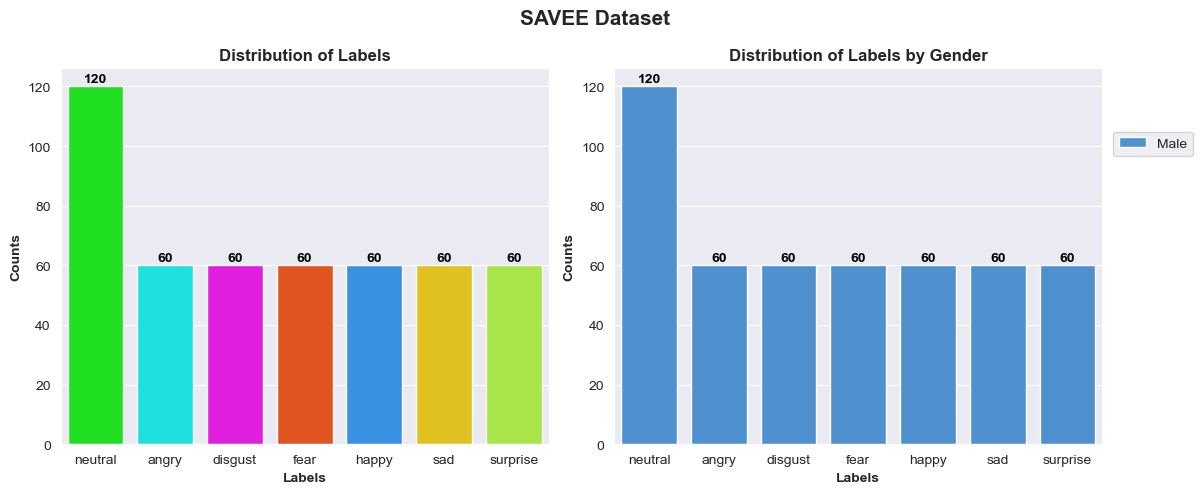

In [476]:
count_plot(SAVEE_df, 'Labels', 'SAVEE')

In [477]:
#Wave
def waveform(samples, sample_rate, file_name):
    plt.figure(figsize=(12,3))
    lb.display.waveshow(samples, sr = sample_rate)
    plt.title(f'Wave of {file_name}')
    plt.ylabel('Amplitude')
    plt.xlabel('Time(s)')
    plt.show()

#Spectrogram
def spectrogram(samples, sample_rate, file_name):
    plt.figure(figsize=(13,3))
    D = lb.amplitude_to_db(np.abs(lb.stft(samples)), ref=np.max)
    lb.display.specshow(D, sr=sample_rate, x_axis = 'time', y_axis = 'log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram of {file_name}')
    plt.ylabel('Frequency(Hz)')
    plt.xlabel('Time(s)')
    plt.show()

#Mel PowerSpectrogram
def mel_spectrogram(samples, sample_rate, file_name):
    plt.figure(figsize=(13,3))
    S = lb.feature.melspectrogram(y=samples, sr=sample_rate, n_mels= 128)
    S_DB = lb.amplitude_to_db(S, ref=np.max)
    lb.display.specshow(S_DB, sr=sample_rate, x_axis = 'time', y_axis = 'mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel Power Spectrogram of {file_name}')
    plt.ylabel('Frequency(Hz)')
    plt.xlabel('Time(s)')
    plt.show()

#MFCC(Mel-Frequency Cepstral Coefficients)
def MFCC(samples, sample_rate, file_name):
    plt.figure(figsize=(13,5))
    mfccs = lb.feature.mfcc(y=samples, sr=sample_rate, n_mfcc=13)
    lb.display.specshow(mfccs, sr=sample_rate, x_axis = 'time')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel-Frequency Cepstral Coefficients(MFCC) of {file_name}')
    plt.ylabel('MFCC coeffs')
    plt.xlabel('Time(s)')
    plt.show()

def audio_plot(df, index):
    file_name = df.path[index]

    print(f'Audio file name : {file_name}')
    ipd.display(ipd.Audio(file_name))

    samples, sample_rate = lb.load(file_name)
    print(f'\nSample Rate     : {sample_rate} \nSamples         : {samples} \n')

    waveform(samples, sample_rate, file_name)

    spectrogram(samples, sample_rate, file_name)

    mel_spectrogram(samples, sample_rate, file_name)

    MFCC(samples, sample_rate, file_name)


Audio file name : ../data/SAVEE/ALL/DC_d11.wav



Sample Rate     : 22050 
Samples         : [0.02923239 0.04258326 0.03758717 ... 0.04064354 0.039179   0.04238518] 



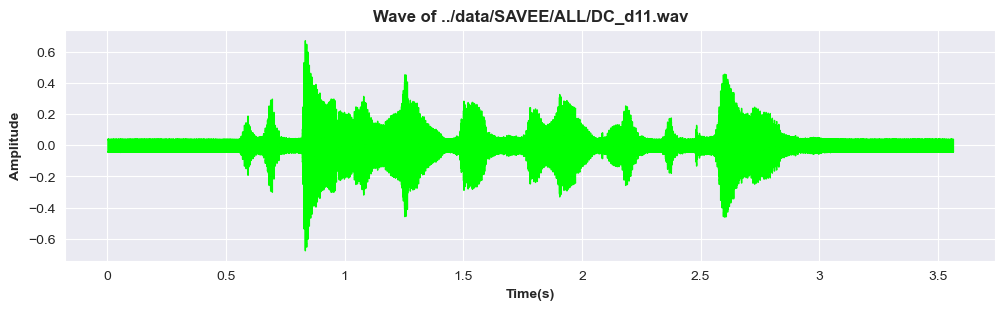

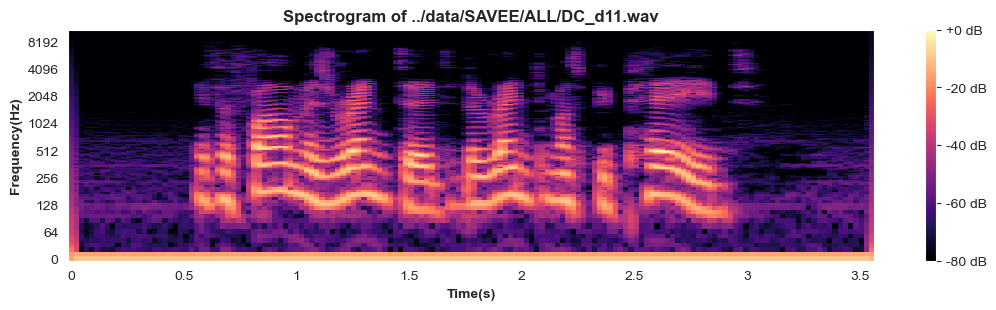

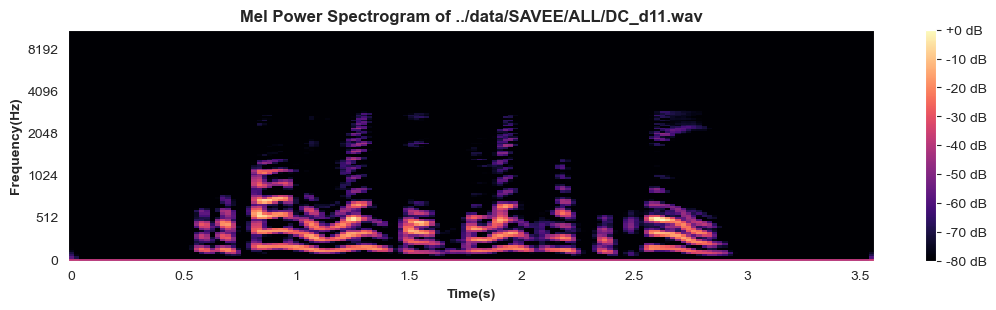

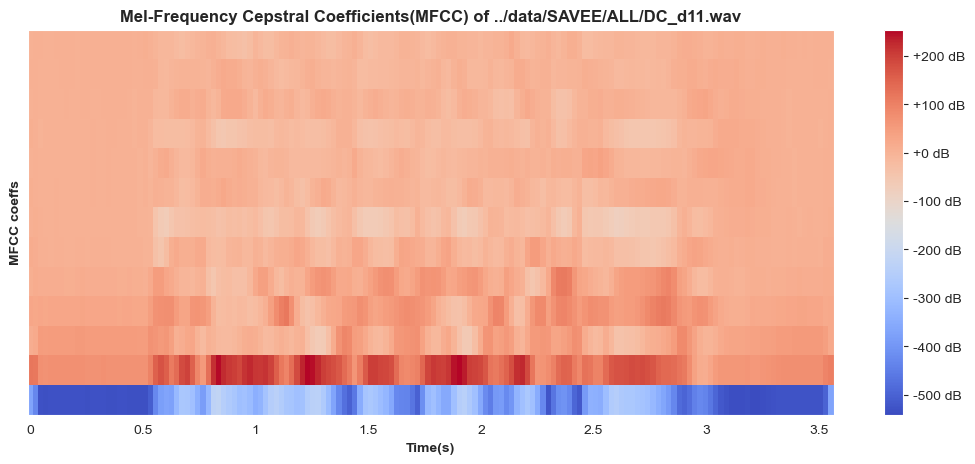

In [478]:
audio_plot(SAVEE_df, 25)

## 2. TESS dataset

- Only female speakers. (2 females - Young and Old)

<u>*Assumptions*</u>

1. Consider all feamles as a single group without differentiating between young and old females.
2. Specilized 'pleasant suprise' is considered a 'suprise'.

In [479]:
dir = os.listdir(tess_path)
dir

['OAF_angry',
 'OAF_disgust',
 'OAF_Fear',
 'OAF_happy',
 'OAF_neutral',
 'OAF_Pleasant_surprise',
 'OAF_Sad',
 'YAF_angry',
 'YAF_disgust',
 'YAF_fear',
 'YAF_happy',
 'YAF_neutral',
 'YAF_pleasant_surprised',
 'YAF_sad']

In [480]:
emotion = []
path = []

patterns = {
    'angry': re.compile(r'(OAF|YAF)_angry', re.IGNORECASE),
    'disgust': re.compile(r'(OAF|YAF)_disgust', re.IGNORECASE),
    'fear': re.compile(r'(OAF|YAF)_fear', re.IGNORECASE),
    'happy': re.compile(r'(OAF|YAF)_happy', re.IGNORECASE),
    'neutral': re.compile(r'(OAF|YAF)_neutral', re.IGNORECASE),
    'surprise': re.compile(r'(OAF|YAF)_(pleasant_surprise|pleasant_surprised)', re.IGNORECASE),
    'sad': re.compile(r'(OAF|YAF)_sad', re.IGNORECASE)
}

for i in os.listdir(tess_path):
    fname = os.listdir(tess_path + i)

    for f in fname:
        matched = False

        for key, pattern in patterns.items():
            if pattern.match(i):
                emotion.append(key)
                matched = True
                break
            if not matched:
                emotion.append('error')

            path.append(os.path.join(tess_path, i, f))

TESS_df = pd.DataFrame({'Labels': emotion, 'Source': 'TESS', 'Gender':'Female'})
path_df = pd.DataFrame({'path': path})
TESS_df = pd.concat([TESS_df, path_df], axis=1)

In [481]:
TESS_df.shape

(11200, 4)

In [482]:
TESS_df.sample(5)

Labels Source  Gender                                               path
7941  error   TESS  Female  ../data/TESS Toronto emotional speech set data...
2633  error   TESS  Female  ../data/TESS Toronto emotional speech set data...
9369  error   TESS  Female                                                NaN
5966  error   TESS  Female  ../data/TESS Toronto emotional speech set data...
3895  error   TESS  Female  ../data/TESS Toronto emotional speech set data...

In [483]:
TESS_df[TESS_df['Labels']=="error"]

Labels Source  Gender                                               path
200    error   TESS  Female  ../data/TESS Toronto emotional speech set data...
202    error   TESS  Female  ../data/TESS Toronto emotional speech set data...
204    error   TESS  Female  ../data/TESS Toronto emotional speech set data...
206    error   TESS  Female  ../data/TESS Toronto emotional speech set data...
208    error   TESS  Female  ../data/TESS Toronto emotional speech set data...
...      ...    ...     ...                                                ...
11194  error   TESS  Female                                                NaN
11195  error   TESS  Female                                                NaN
11196  error   TESS  Female                                                NaN
11197  error   TESS  Female                                                NaN
11198  error   TESS  Female                                                NaN

[8400 rows x 4 columns]

In [484]:
TESS_df['Labels'].value_counts()

Labels
error       8400
angry        400
disgust      400
fear         400
happy        400
neutral      400
surprise     400
sad          400
Name: count, dtype: int64

In [485]:
TESS_df = TESS_df[TESS_df['Labels'] != "error"]

In [486]:
TESS_df.shape

(2800, 4)

In [487]:
TESS_df['Labels'].value_counts()

Labels
angry       400
disgust     400
fear        400
happy       400
neutral     400
surprise    400
sad         400
Name: count, dtype: int64

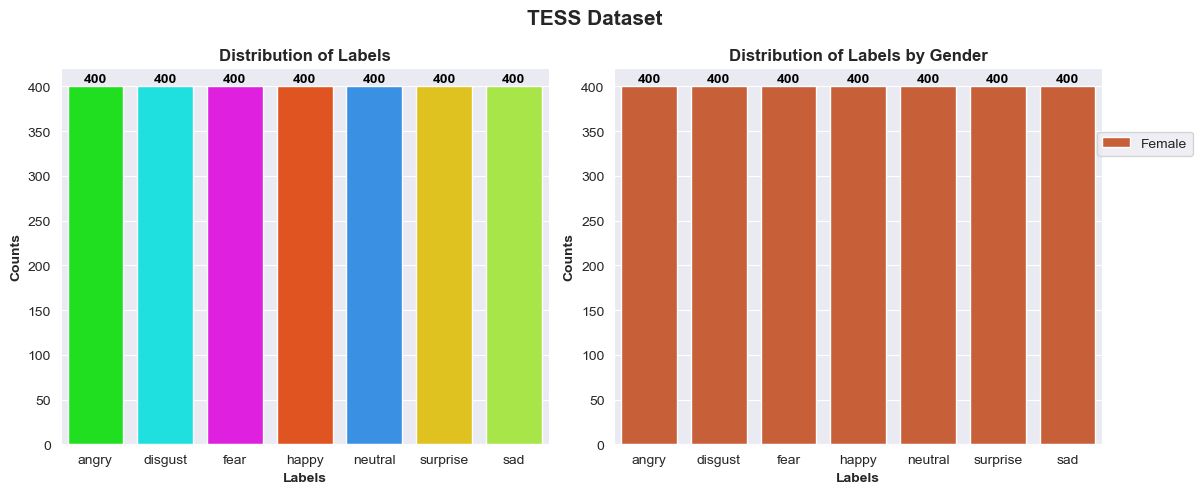

In [488]:
count_plot(TESS_df, 'Labels','TESS')

Audio file name : ../data/TESS Toronto emotional speech set data/OAF_disgust\OAF_dab_disgust.wav



Sample Rate     : 22050 
Samples         : [2.0802595e-06 1.0145905e-04 1.4958496e-04 ... 7.0398283e-04 6.0539861e-04
 3.0529770e-04] 



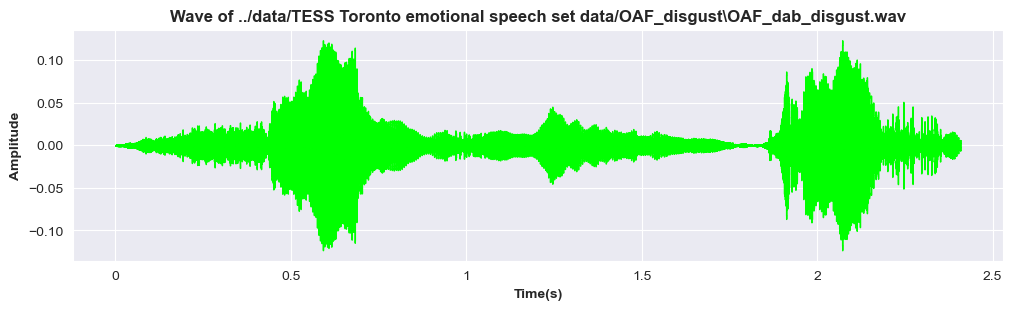

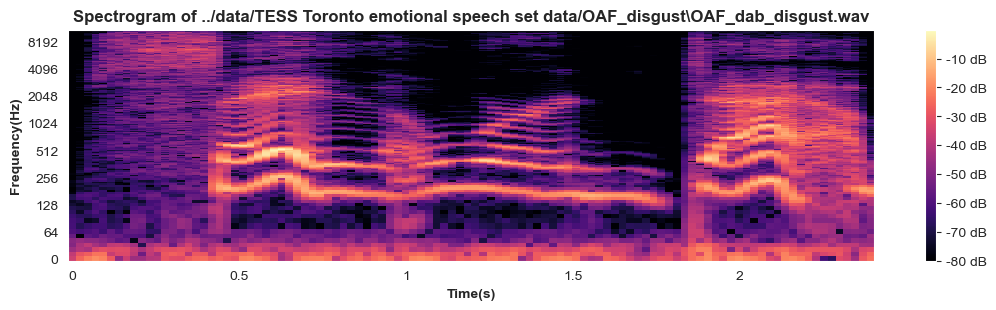

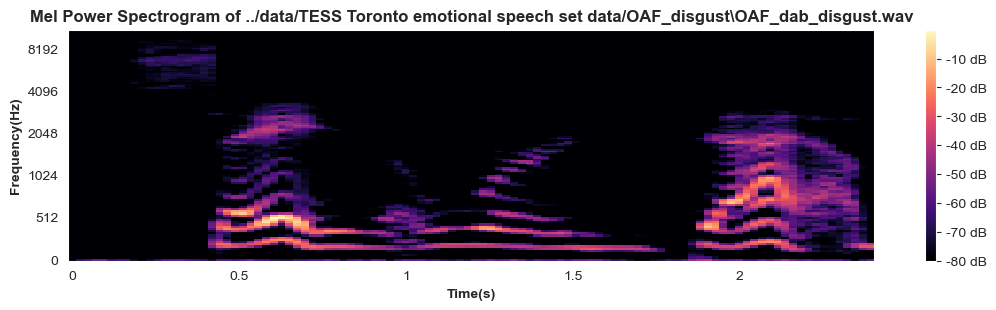

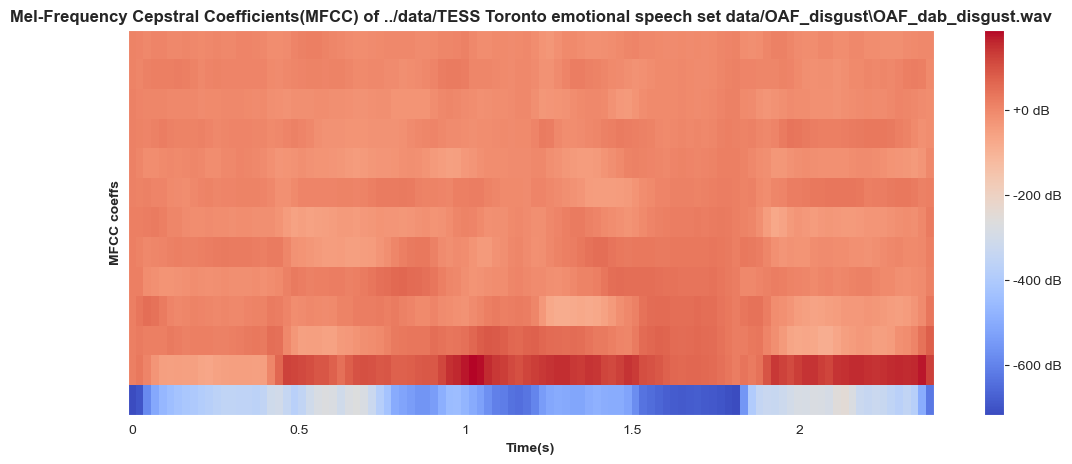

In [489]:
audio_plot(TESS_df, 25)

## 3. CREMA-D dataset

- Includes different speakers for different ethinicities.
- 'Suprise' emotion is missing.
- There are 91 actors.(48-Male, 43-Female)
- There 12 sentences.

    | Sentences                                | Acronym |
    |------------------------------------------|---------|
    | It's eleven o'clock                      | IEO     |
    | That is exactly what happened            | TIE     |
    | I'm on my way to the meeting             | IOM     |
    | I wonder what this is about              | IWW     |
    | The airplane is almost full              | TAI     |
    | Maybe tomorrow it will be cold           | MTI     |
    | I would like a new alarm clock           | IWL     |
    | I think I have a doctor's appointment    | ITH     |
    | Don't forget a jacket                    | DFA     |
    | I think I've seen this before            | ITS     |
    | The surface is slick                     | TSI     |
    | We'll stop in a couple of minutes        | WSI     |


-  There are 6 types of emotions (No suprise).

    | Emotion Code | Emotion  |
    |--------------|----------|
    | ANG          | angry    |
    | DIS          | disgust  |
    | FEA          | fear     |
    | HAP          | happy    |
    | NEU          | neutral  |
    | SAD          | sad      |

In [490]:
print(os.listdir(cremad_path)[0:10])

['1001_DFA_ANG_XX.wav', '1001_DFA_DIS_XX.wav', '1001_DFA_FEA_XX.wav', '1001_DFA_HAP_XX.wav', '1001_DFA_NEU_XX.wav', '1001_DFA_SAD_XX.wav', '1001_IEO_ANG_HI.wav', '1001_IEO_ANG_LO.wav', '1001_IEO_ANG_MD.wav', '1001_IEO_DIS_HI.wav']


In [491]:
path = []
actor_ids = []
emotion = []

mapping = {
    'ANG': 'angry',
    'DIS': 'disgust',
    'FEA': 'fear',
    'HAP': 'happy',
    'NEU': 'neutral',
    'SAD': 'sad',
    'SUR': 'surprise'
}

reg_pattern = re.compile(r'(\d{4})_.*?_(\w{3})_')

for fname in os.listdir(cremad_path):
    if fname.endswith('.wav'):
        match = reg_pattern.match(fname)
        if match:
            actor_id = match.group(1)
            emo_code = match.group(2)
            label = mapping.get(emo_code, 'error')
            actor_ids.append(actor_id)
            emotion.append(label)
            path.append(os.path.join(cremad_path, fname))

CREMAD_df = pd.DataFrame({'Labels': emotion, 'Source': 'CREMAD','actor_id':actor_ids})
path_df = pd.DataFrame({'path': path})
CREMAD_df = pd.concat([CREMAD_df, path_df], axis=1)

In [492]:
CREMAD_df.shape

(7442, 4)

In [493]:
CREMAD_df.sample(5)

Labels  Source actor_id                                          path
737      fear  CREMAD     1010  ../data/CREMA-D/AudioWAV\1010_IEO_FEA_HI.wav
6848  neutral  CREMAD     1084  ../data/CREMA-D/AudioWAV\1084_TAI_NEU_XX.wav
4617  neutral  CREMAD     1057  ../data/CREMA-D/AudioWAV\1057_IWL_NEU_XX.wav
7138     fear  CREMAD     1088  ../data/CREMA-D/AudioWAV\1088_IOM_FEA_XX.wav
3125    angry  CREMAD     1039  ../data/CREMA-D/AudioWAV\1039_ITH_ANG_XX.wav

In [494]:
CREMAD_df['Labels'].value_counts()

Labels
angry      1271
disgust    1271
fear       1271
happy      1271
sad        1271
neutral    1087
Name: count, dtype: int64

In [495]:
#demographics 
crema_demo_df = pd.read_csv('../data/CREMA-D/VideoDemographics.csv')
print(crema_demo_df.shape)

(91, 5)


In [496]:
crema_demo_df.head()

ActorID  Age     Sex              Race     Ethnicity
0     1001   51    Male         Caucasian  Not Hispanic
1     1002   21  Female         Caucasian  Not Hispanic
2     1003   21  Female         Caucasian  Not Hispanic
3     1004   42  Female         Caucasian  Not Hispanic
4     1005   29    Male  African American  Not Hispanic

In [497]:
crema_demo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ActorID    91 non-null     int64 
 1   Age        91 non-null     int64 
 2   Sex        91 non-null     object
 3   Race       91 non-null     object
 4   Ethnicity  91 non-null     object
dtypes: int64(2), object(3)
memory usage: 3.7+ KB


In [498]:
CREMAD_df['actor_id'] = CREMAD_df['actor_id'].astype('int')

In [499]:
CREMAD_detailed_df = pd.merge(crema_demo_df, CREMAD_df, left_on='ActorID', right_on='actor_id', how='inner')

In [500]:
CREMAD_detailed_df.shape

(7442, 9)

In [501]:
CREMAD_detailed_df.sample(5)

ActorID  Age     Sex              Race     Ethnicity   Labels  Source  \
6315     1078   21  Female         Caucasian  Not Hispanic      sad  CREMAD   
6444     1079   21  Female         Caucasian      Hispanic  neutral  CREMAD   
2107     1026   33    Male         Caucasian  Not Hispanic    angry  CREMAD   
2081     1026   33    Male         Caucasian  Not Hispanic  neutral  CREMAD   
3363     1042   37    Male  African American  Not Hispanic      sad  CREMAD   

      actor_id                                          path  
6315      1078  ../data/CREMA-D/AudioWAV\1078_IEO_SAD_MD.wav  
6444      1079  ../data/CREMA-D/AudioWAV\1079_TIE_NEU_XX.wav  
2107      1026  ../data/CREMA-D/AudioWAV\1026_WSI_ANG_XX.wav  
2081      1026  ../data/CREMA-D/AudioWAV\1026_IWW_NEU_XX.wav  
3363      1042  ../data/CREMA-D/AudioWAV\1042_IEO_SAD_LO.wav

In [502]:
CREMAD_detailed_df = CREMAD_detailed_df.rename(columns={'Sex': 'Gender'})

In [503]:
CREMAD_detailed_df.groupby('Gender')['Labels'].value_counts()

Gender  Labels 
Female  angry      600
        disgust    600
        fear       600
        happy      600
        sad        600
        neutral    512
Male    angry      671
        disgust    671
        fear       671
        happy      671
        sad        671
        neutral    575
Name: count, dtype: int64

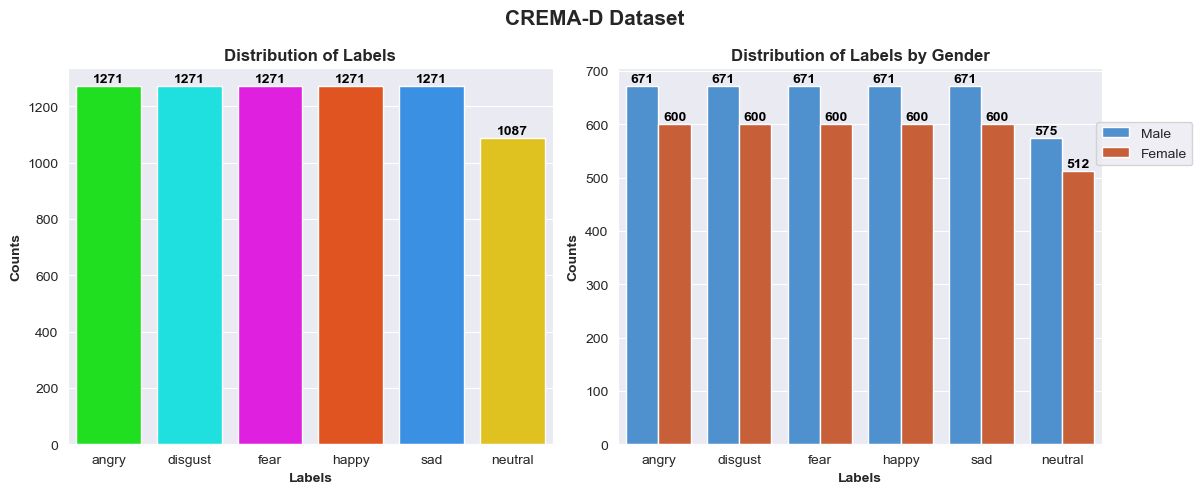

In [504]:
count_plot(CREMAD_detailed_df, 'Labels', 'CREMA-D')

Audio file name : ../data/CREMA-D/AudioWAV\1001_IOM_HAP_XX.wav



Sample Rate     : 22050 
Samples         : [ 1.2928119e-03  1.6535702e-03  1.6670754e-03 ...  7.7503351e-12
 -1.3347955e-11  0.0000000e+00] 



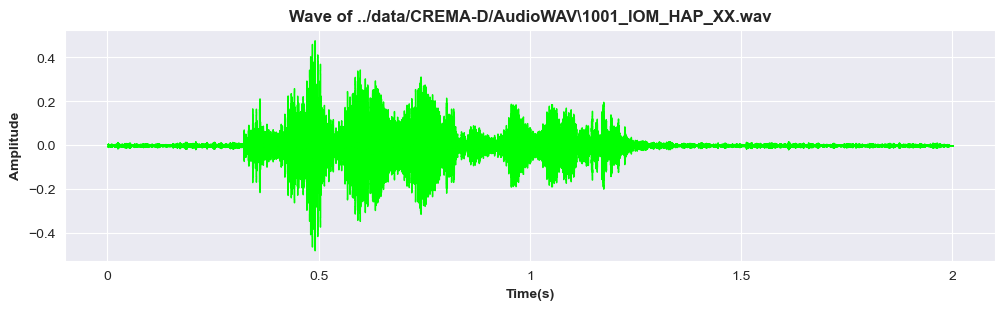

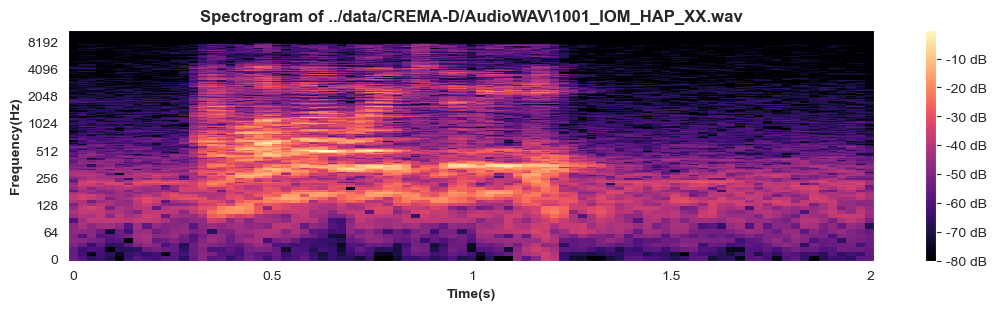

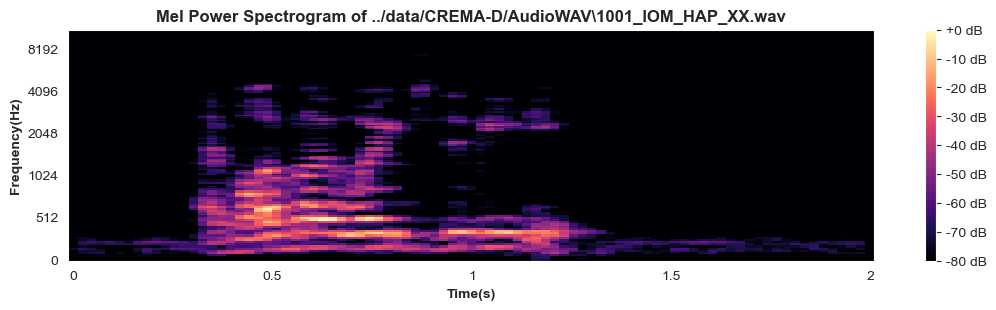

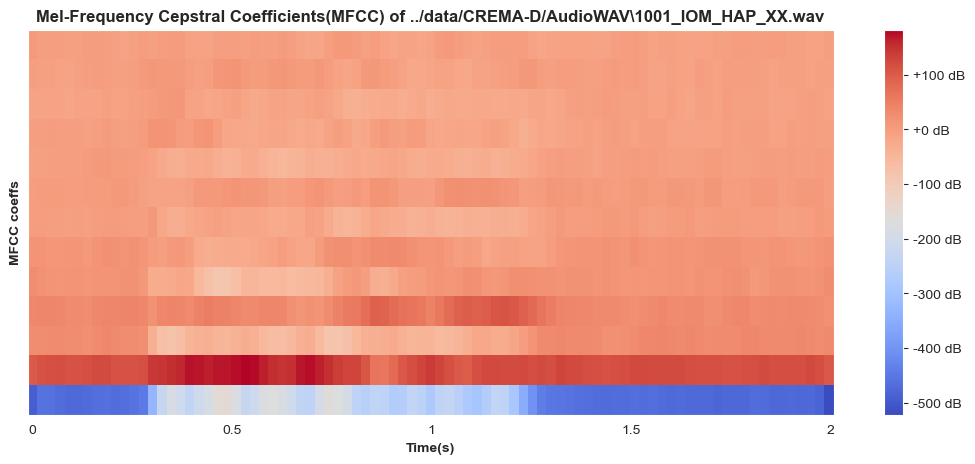

In [505]:
audio_plot(CREMAD_detailed_df, 25)

## 4. RAVDESS dataset

- includes both speeches and songs.

In [506]:
print(os.listdir(ravdess_path)[0:10])

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10']


In [520]:
emotion = []
gender = []
path = []

for i in os.listdir(ravdess_path):
    fname = os.listdir(ravdess_path + i)
    for f in fname:
        temp = f.split('.')[0].split('-')
        emotion.append(int(temp[2]))
        temp1 = int(temp[6])

        if temp1 %2 ==0:
            temp2 = 'Female'
        else:
            temp2 = 'Male'
        
        gender.append(temp2)
        path.append(ravdess_path + i + '/' +f)

RAVDESS_df = pd.DataFrame({'Labels':emotion, 'Gender': gender, 'Source':'RAVDESS'})

mapping = {1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}
RAVDESS_df['Labels'] = RAVDESS_df['Labels'].map(mapping)
path_df = pd.DataFrame({'path': path})
RAVDESS_df = pd.concat([RAVDESS_df, path_df], axis=1)

In [521]:
RAVDESS_df.sample(5)

Labels  Gender   Source  \
1170    angry  Female  RAVDESS   
1191  disgust  Female  RAVDESS   
34      angry    Male  RAVDESS   
198     happy  Female  RAVDESS   
453     angry  Female  RAVDESS   

                                                   path  
1170  ../data/RAVDESS/audio_speech_actors_01-24/Acto...  
1191  ../data/RAVDESS/audio_speech_actors_01-24/Acto...  
34    ../data/RAVDESS/audio_speech_actors_01-24/Acto...  
198   ../data/RAVDESS/audio_speech_actors_01-24/Acto...  
453   ../data/RAVDESS/audio_speech_actors_01-24/Acto...

In [509]:
RAVDESS_df['Labels'].value_counts()

Labels
neutral     288
happy       192
sad         192
angry       192
fear        192
disgust     192
surprise    192
Name: count, dtype: int64

In [510]:
RAVDESS_df.groupby('Gender')['Labels'].value_counts()

Gender  Labels  
Female  neutral     144
        angry        96
        disgust      96
        fear         96
        happy        96
        sad          96
        surprise     96
Male    neutral     144
        angry        96
        disgust      96
        fear         96
        happy        96
        sad          96
        surprise     96
Name: count, dtype: int64

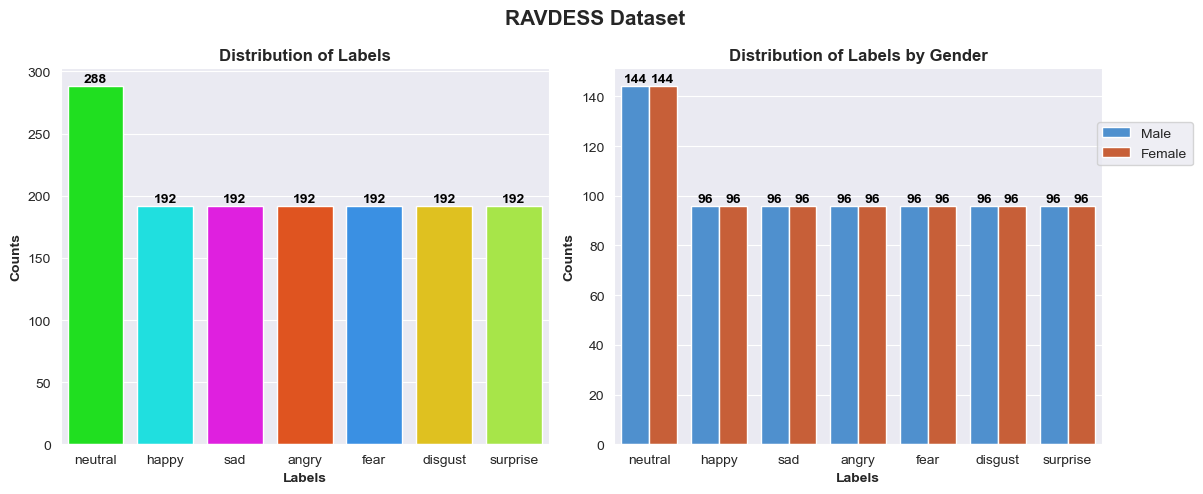

In [511]:
count_plot(RAVDESS_df, 'Labels', 'RAVDESS')

Audio file name : ../data/RAVDESS/audio_speech_actors_01-24/Actor_01/03-01-04-02-01-02-01.wav



Sample Rate     : 22050 
Samples         : [ 4.3061231e-14  1.9672266e-13  7.2149528e-14 ... -2.3806250e-13
 -2.2418325e-13  2.0970706e-14] 



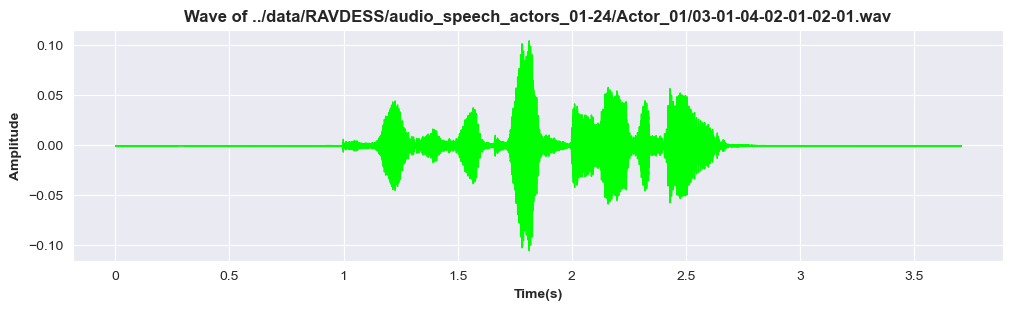

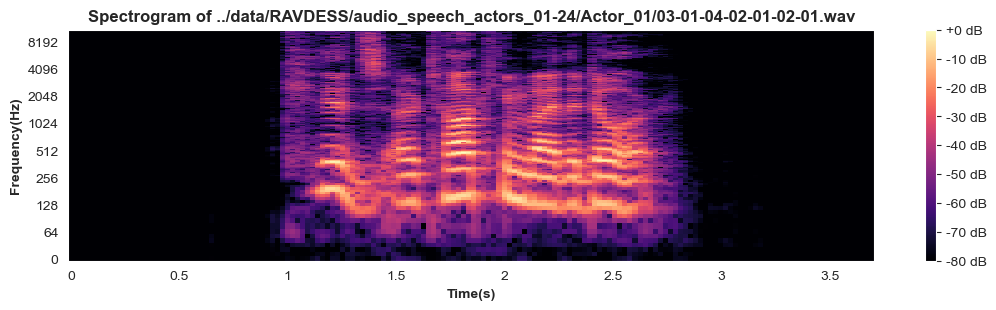

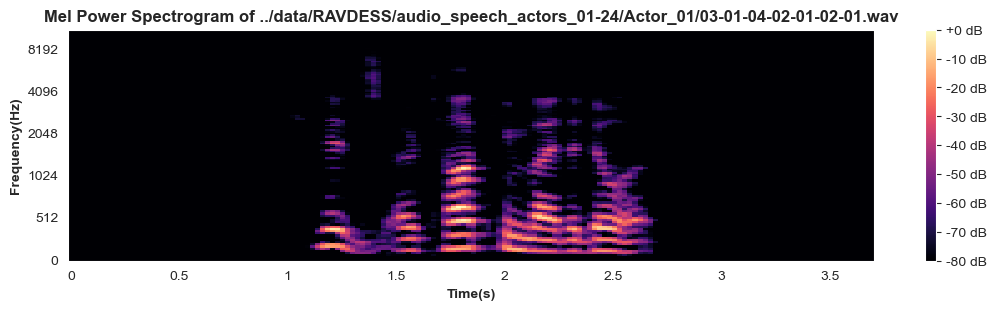

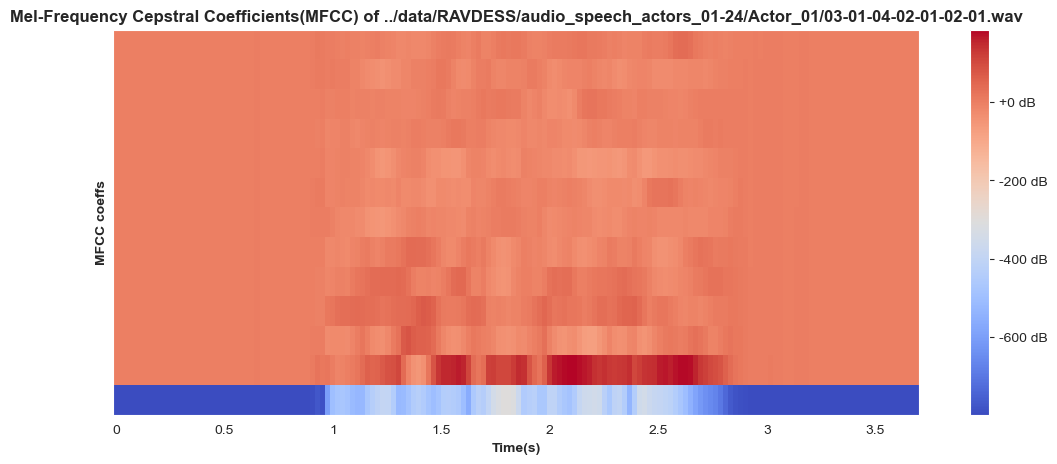

In [512]:
audio_plot(RAVDESS_df, 25)

In [513]:
CREMAD_detailed_df.columns

Index(['ActorID', 'Age', 'Gender', 'Race', 'Ethnicity', 'Labels', 'Source',
       'actor_id', 'path'],
      dtype='object')

In [514]:
CREMAD_df = CREMAD_detailed_df.drop(['ActorID', 'Age', 'Race', 'Ethnicity', 'actor_id'], axis=1)

In [526]:
cols_order = ['Labels',	'Source', 'Gender',	'path']

In [527]:
CREMAD_df = CREMAD_df[cols_order]
RAVDESS_df = RAVDESS_df[cols_order]

In [528]:
CREMAD_df.head()

Labels  Source Gender                                          path
0    angry  CREMAD   Male  ../data/CREMA-D/AudioWAV\1001_DFA_ANG_XX.wav
1  disgust  CREMAD   Male  ../data/CREMA-D/AudioWAV\1001_DFA_DIS_XX.wav
2     fear  CREMAD   Male  ../data/CREMA-D/AudioWAV\1001_DFA_FEA_XX.wav
3    happy  CREMAD   Male  ../data/CREMA-D/AudioWAV\1001_DFA_HAP_XX.wav
4  neutral  CREMAD   Male  ../data/CREMA-D/AudioWAV\1001_DFA_NEU_XX.wav

In [529]:
RAVDESS_df.head()

Labels   Source Gender                                               path
0  neutral  RAVDESS   Male  ../data/RAVDESS/audio_speech_actors_01-24/Acto...
1  neutral  RAVDESS   Male  ../data/RAVDESS/audio_speech_actors_01-24/Acto...
2  neutral  RAVDESS   Male  ../data/RAVDESS/audio_speech_actors_01-24/Acto...
3  neutral  RAVDESS   Male  ../data/RAVDESS/audio_speech_actors_01-24/Acto...
4  neutral  RAVDESS   Male  ../data/RAVDESS/audio_speech_actors_01-24/Acto...

In [530]:
TESS_df.head()

Labels Source  Gender                                               path
0  angry   TESS  Female  ../data/TESS Toronto emotional speech set data...
1  angry   TESS  Female  ../data/TESS Toronto emotional speech set data...
2  angry   TESS  Female  ../data/TESS Toronto emotional speech set data...
3  angry   TESS  Female  ../data/TESS Toronto emotional speech set data...
4  angry   TESS  Female  ../data/TESS Toronto emotional speech set data...

In [531]:
SAVEE_df.head()

Labels Source Gender                          path
0  angry  SAVEE   Male  ../data/SAVEE/ALL/DC_a01.wav
1  angry  SAVEE   Male  ../data/SAVEE/ALL/DC_a02.wav
2  angry  SAVEE   Male  ../data/SAVEE/ALL/DC_a03.wav
3  angry  SAVEE   Male  ../data/SAVEE/ALL/DC_a04.wav
4  angry  SAVEE   Male  ../data/SAVEE/ALL/DC_a05.wav

In [533]:
df = pd.concat([SAVEE_df, RAVDESS_df, TESS_df, CREMAD_df], axis = 0)

In [534]:
df['Labels'].value_counts()

Labels
angry       1923
disgust     1923
fear        1923
happy       1923
sad         1923
neutral     1895
surprise     652
Name: count, dtype: int64

In [535]:
df.groupby('Gender')['Labels'].value_counts()

Gender  Labels  
Female  angry       1096
        disgust     1096
        fear        1096
        happy       1096
        sad         1096
        neutral     1056
        surprise     496
Male    neutral      839
        angry        827
        disgust      827
        fear         827
        happy        827
        sad          827
        surprise     156
Name: count, dtype: int64